In [88]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

In [30]:
cases_text_onlyspeaker_df = pd.read_csv("cases_text_onlyspeaker.csv")
cases_text_onlyspeaker_df.head()

,new_name,sentence,sentence_clean,topic_mentioned,sentiment,prob_score_neg,prob_score_neutral,prob_score_pos,has_parking,has_econactivity,...,sent_voice_mentioned,sentpol_voice_mentioned,prob_pos_voice_mentioned,prob_neg_voice_mentioned,positive_voice_mentioned,negative_voice_mentioned,num_voice_mentioned,num_sentences,sentence_lower,count_my_name
0,09-12-2017audio_6ZA-2017-210-CU-1A,My name is Jerry Newman.,My name is Jerry Newman.,NaN,NaN,NaN,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,my name is jerry newman.,1
1,09-12-2017audio_6ZA-2017-210-CU-1A,"Thank you, President Chunkham, members of the ...","Thank you, President Chunkham, members of the ...",NaN,NaN,NaN,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,"thank you, president chunkham, members of the ...",0
2,09-12-2017audio_6ZA-2017-210-CU-1A,The question that is asked and that was asked ...,The question that is asked and that was asked ...,NaN,NaN,NaN,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,the question that is asked and that was asked ...,0
3,09-12-2017audio_6ZA-2017-210-CU-1A,And I think Mr. Chang made an adequate descrip...,And I think Mr. Chang made an adequate descrip...,NaN,NaN,NaN,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,and i think mr. chang made an adequate descrip...,0
4,09-12-2017audio_6ZA-2017-210-CU-1A,We started thinking through a business plan an...,We started thinking through a business plan an...,NaN,NaN,NaN,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,we started thinking through a business plan an...,0


Load Sentence Embedding Model

In [31]:
model = SentenceTransformer('all-MiniLM-L6-v2')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Get Embeddings

In [32]:
def get_embeddings(column):
  parking_rows = cases_text_onlyspeaker_df[cases_text_onlyspeaker_df[column] == 1]
  all_sentences = parking_rows["sentence"].tolist()
  
  return model.encode(all_sentences), all_sentences

Get Optimal k Clusters (Elbow Test)

In [33]:
def elbow_test(embeddings):
  inertias = []
  k_values = range(1, 20)

  for k in k_values:
      clustering_model = KMeans(n_clusters=k, random_state=0)
      clustering_model.fit(embeddings)
      inertias.append(clustering_model.inertia_)

  plt.figure(figsize=(8, 4))
  plt.plot(k_values, inertias, 'bo-')
  plt.xlabel('Number of Clusters (k)')
  plt.ylabel('Inertia (Sum of Squared Distances)')
  plt.title('Elbow Test for Optimal k')
  plt.grid(True)
  plt.show()

K-means Classifier

In [167]:
# def k_means_classifier(embeddings, num_clusters = 8, seed = 42):
#   clustering_model = KMeans(n_clusters=num_clusters, random_state=seed)
#   clustering_model.fit(embeddings)
#   clusters = clustering_model.labels_

#   return clusters


def k_means_classifier(embeddings, num_clusters=8, seed=42, n_init=10):
    n_samples = embeddings.shape[0]
    consensus_matrix = np.zeros((n_samples, n_samples))

    # Run K-means with random initializations and update the consensus matrix
    for i in range(n_init):
        # K-Means with a different random seed each time for diverse initialization
        clustering_model = KMeans(n_clusters=num_clusters, random_state=seed + i)
        clustering_model.fit(embeddings)
        clusters = clustering_model.labels_
        
        # Update the consensus matrix
        for j in range(n_samples):
            for k in range(j + 1, n_samples):
                if clusters[j] == clusters[k]:
                    consensus_matrix[j, k] += 1
                    consensus_matrix[k, j] += 1

    # Normalizing the consensus matrix
    consensus_matrix /= n_init
    
    # Final clustering using the consensus matrix
    final_clustering_model = KMeans(n_clusters=num_clusters, random_state=seed)
    final_clustering_model.fit(consensus_matrix)
    final_clusters = final_clustering_model.labels_

    return final_clusters


Visualize Clusters

In [35]:
def pca_plot(embeddings, clusters):
  pca = PCA(n_components=3)
  pca_result = pca.fit_transform(embeddings)

  fig = plt.figure(figsize=(10, 7))
  ax = fig.add_subplot(111, projection='3d')

  scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=clusters, cmap='rainbow', alpha=0.7)
  ax.view_init(elev=30, azim=120)


  ax.set_title('3D PCA of Sentence Embeddings with K-Means Clustering')
  ax.set_xlabel('PCA Component 1')
  ax.set_ylabel('PCA Component 2')
  ax.set_zlabel('PCA Component 3')

  plt.colorbar(scatter, ax=ax, label='Cluster ID')
  plt.show()

In [36]:
def example_sentences(clustered_sentences, num_clusters, samples):
  for i in range(num_clusters):
      print(f"\nCluster {i}:")
      example_sentences = clustered_sentences[clustered_sentences['Cluster'] == i]['Sentence'].sample(samples)
      for sentence in example_sentences:
          print(f"- {sentence}")

In [37]:
def display_cluster_breakdown(clusters_df, cluster_labels):
  cluster_counts = clusters_df['Cluster'].value_counts().sort_index()
  total_sentences = cluster_counts.sum()

  cluster_data = []
  for cluster_num, count in cluster_counts.items():
      percentage = (count / total_sentences) * 100
      label = cluster_labels[cluster_num]
      cluster_data.append({
          'Cluster': cluster_num,
          'Pct of Sentences': f"{percentage:.2f}%",
          'Manual Guessed Label': label
      })

  cluster_breakdown_df = pd.DataFrame(cluster_data)
  cluster_breakdown_df.set_index('Cluster', inplace=True)

  return cluster_breakdown_df

Topic: Parking

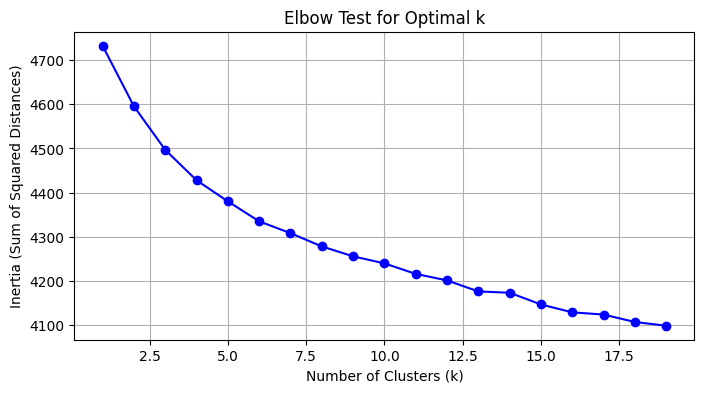

In [38]:
parking_embeddings, parking_sentences = get_embeddings('has_parking')
elbow_test(parking_embeddings)

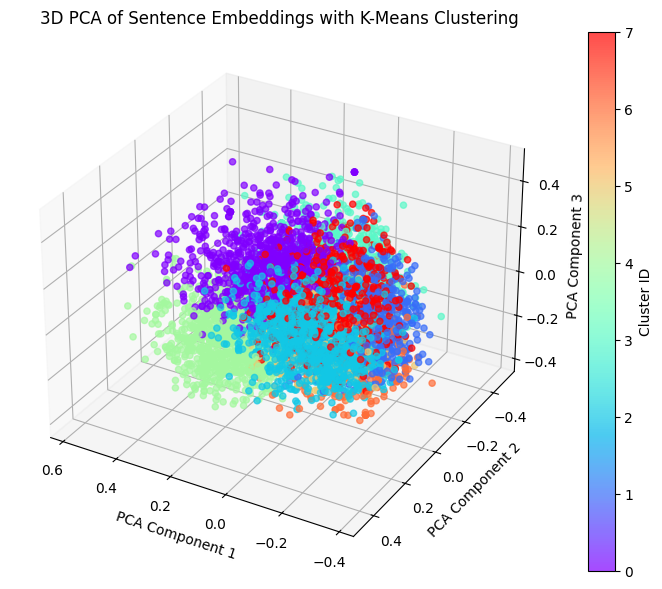

In [118]:
parking_num_clusters = 8
parking_clusters = k_means_classifier(parking_embeddings, num_clusters=parking_num_clusters, seed=42, n_init=10)

parking_clusters_df = pd.DataFrame({'Sentence': parking_sentences, 'Cluster': parking_clusters})
pca_plot(parking_embeddings, parking_clusters)

In [125]:
parking_example_sentences = 4
example_sentences(parking_clusters_df, parking_num_clusters, parking_example_sentences)


Cluster 0:
- I think what theyve planned for is a valley for onsite only to meet their parking requirements and to assist in the circulation there in that parking lot.
- The normal parking spaces and landscaping of the project compares fervorably to these buildings.
- So the ultimate design that theyll be looking at is this one with the facility to the southeast cornerthe driveway, a straight driveway with a little drop-off lane over here and then the three parking lots.
- And I understand this guy wants to make some money on his building but I also have a life and I care about my life and I think whats happening in LA overall is that so many of these buildings are being torn down and theyre being replaced with condosor high price department buildings and affordable apartments are just going away and theres a problem with supply and demand and as these department buildings get demolished the poor bull parking buildings that are left are going up in price.

Cluster 1:
- The neighborhoo

In [166]:
parking_cluster_labels = {
    0: "parking design/infrastructure relative to the proposed project",
    1: "issues and inadequacies of parking on community",
    2: "physical location of parking",
    3: "beauracracy, compliance with regulations, application",
    4: "specific amount parking space requirements",
    5: " ",
    6: "lack of parking",
    7: " "
}


parking_cluster_breakdown_df = display_cluster_breakdown(parking_clusters_df, parking_cluster_labels)
parking_cluster_breakdown_df

,Pct of Sentences,Manual Guessed Label
Cluster,,
0,14.21%,parking design/infrastructure relative to the ...
1,15.39%,issues and inadequacies of parking on community
2,15.19%,physical location of parking
3,14.69%,"beauracracy, compliance with regulations, appl..."
4,12.96%,specific amount parking space requirements
5,12.62%,
6,5.18%,lack of parking
7,9.76%,


Topic: Nuisance

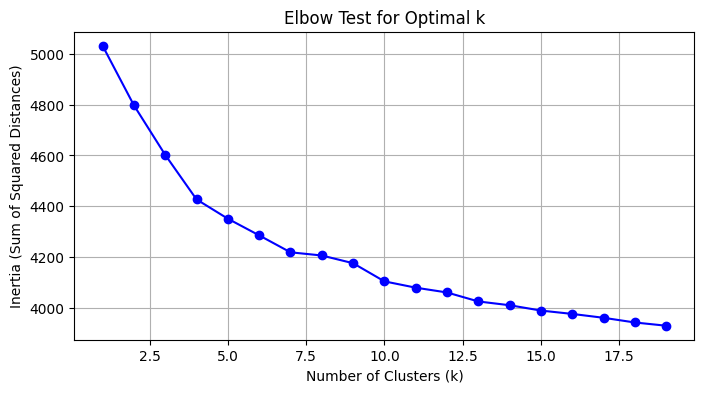

In [42]:
nuisance_embeddings, nuisance_sentences = get_embeddings('has_nuisance')
elbow_test(nuisance_embeddings)

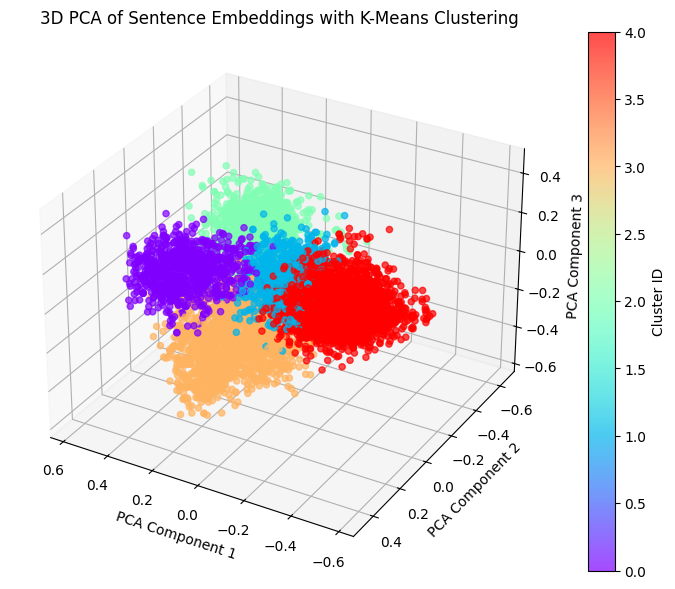

In [126]:
nuisance_num_clusters = 5
nuisance_clusters = k_means_classifier(nuisance_embeddings, num_clusters=nuisance_num_clusters, seed=42, n_init=10)
nuisance_clusters_df = pd.DataFrame({'Sentence': nuisance_sentences, 'Cluster': nuisance_clusters})
pca_plot(nuisance_embeddings, nuisance_clusters)

In [137]:
nuisance_example_sentences = 4
example_sentences(nuisance_clusters_df, nuisance_num_clusters, nuisance_example_sentences)


Cluster 0:
- Thats what I mean so were looking at 10,170, Im sorry, 8,000 square feet of open space.
- The Mulholland scenic parkway a very special place that preserves the beauty of nature and open space right in the middle of the city.
- But Rene, you also express concerns with regards to the size of the open space as a percentage of the project.
- However, Im very concerned that that school does not have their open space.

Cluster 1:
- They cited that the project is still too large in size, that the overflow parking would adversely impact the on-street parkingin the single family residential neighborhoods, and that the applicant has not provided adequate traffic mitigation.
- The environmental impact report was prepared by ESA and was prepared by qualified experts in the air quality and GHG.
- But it should not be a church what I believe it should be as a park, a skate park, a dog park, just a park to sit and watch the traffic go by.
- Greenhouseand urban heat island effect is also

In [147]:
nuisance_cluster_labels = {
    0: "importance and management of open spaces",
    1: "community concerns about development impacts",
    2: "noise, privacy",
    3: "security, crime",
    4: "traffic, local infrastructure"
}


nuisance_cluster_breakdown_df = display_cluster_breakdown(nuisance_clusters_df, nuisance_cluster_labels)
nuisance_cluster_breakdown_df

,Pct of Sentences,Manual Guessed Label
Cluster,,
0,13.37%,importance and management of open spaces
1,9.74%,community concerns about development impacts
2,18.32%,"noise, privacy"
3,23.42%,"security, crime"
4,35.14%,"traffic, local infrastructure"


Topic: Affordable Housing

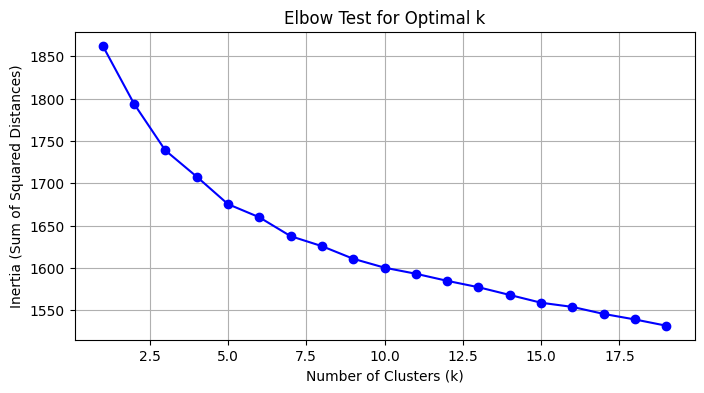

In [139]:
affordable_housing_embeddings, affordable_housing_sentences = get_embeddings('has_affordablehousing')
elbow_test(affordable_housing_embeddings)

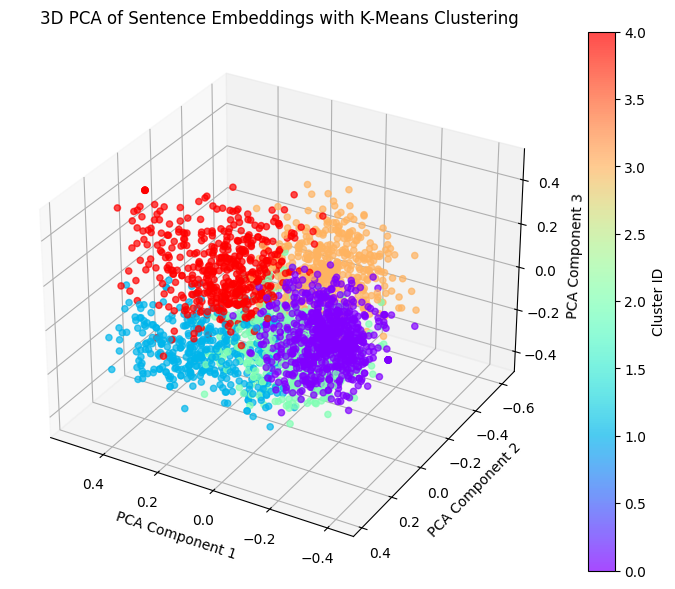

In [140]:
affordable_housing_num_clusters = 5
affordable_housing_clusters = k_means_classifier(affordable_housing_embeddings, num_clusters=affordable_housing_num_clusters, seed=42, n_init=10)
affordable_housing_clusters_df = pd.DataFrame({'Sentence': affordable_housing_sentences, 'Cluster': affordable_housing_clusters})
pca_plot(affordable_housing_embeddings, affordable_housing_clusters)

In [163]:
affordable_housing_example_sentences = 4
example_sentences(affordable_housing_clusters_df, affordable_housing_num_clusters, affordable_housing_example_sentences)


Cluster 0:
- The bottom line to me is that theres a need for more senior housing, theres a need for affordable housing.
- I mean one of the major issues I think we need to talk about is you know housing supply and how all housing fits together theres a saying in academia which is the best way to build affordable housing is to build luxury housing 20 years ago.
- I do agree with Commissioner Milton and Commissioner Perlmanand about aesthetically the building not necessarily reflecting the area, I too dont know exactly how we can affect that, but certainly to me it doesnt matternot fit into the traditional aesthetics of the area which actually I think are some of the most, one of the most unique parts of the entire I will echo when everyone has said about affordable housing.
- It will provide needed affordable housing, particularly west of the the 405 where theres very little and it will replace an obsolete, unpedestrian friendly strip retail.

Cluster 1:
- It really is a scale so the m

In [165]:
affordable_housing_cluster_labels = {
    0: "challenges of providing affordable housing",
    1: " ",
    2: "impact of development on community",
    3: "rent, tenant issues",
    4: "cost, affordability"
}


affordable_housing_cluster_breakdown_df = display_cluster_breakdown(affordable_housing_clusters_df, affordable_housing_cluster_labels)
affordable_housing_cluster_breakdown_df

,Pct of Sentences,Manual Guessed Label
Cluster,,
0,27.36%,challenges of providing affordable housing
1,15.33%,
2,23.14%,impact of development on community
3,16.75%,"rent, tenant issues"
4,17.42%,"cost, affordability"


Topic: Neighborhood Character

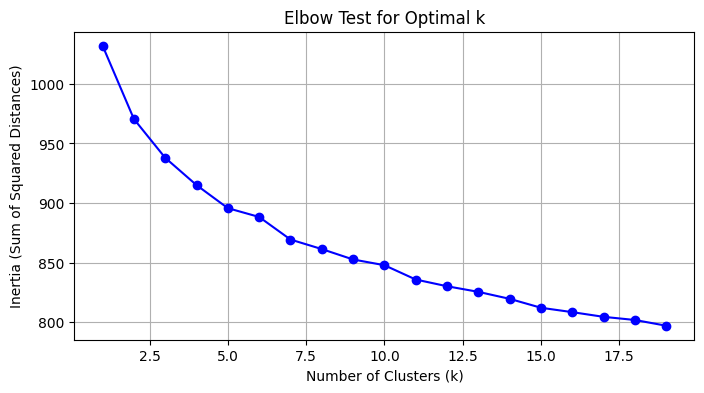

In [143]:
neighborhood_char_embeddings, neighborhood_char_sentences = get_embeddings('has_nhood_character')
elbow_test(neighborhood_char_embeddings)

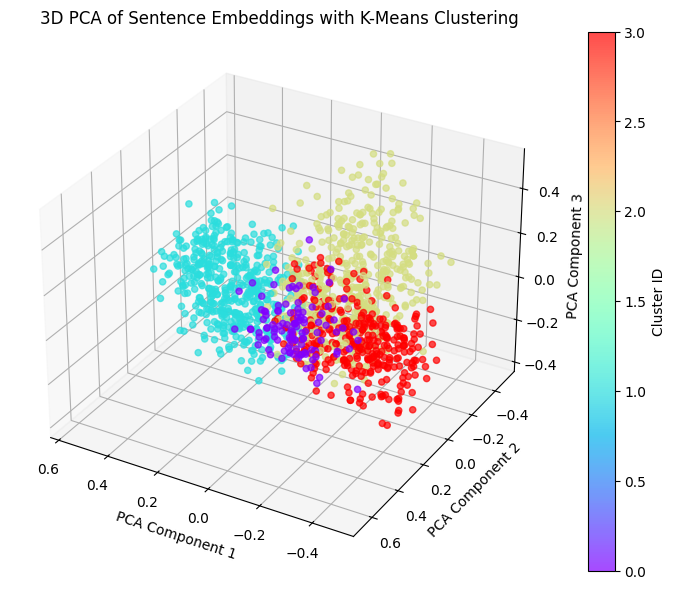

In [144]:
neighborhood_char_num_clusters = 4
neighborhood_char_clusters = k_means_classifier(neighborhood_char_embeddings, num_clusters=neighborhood_char_num_clusters, seed=42, n_init=10)
neighborhood_char_clusters_df = pd.DataFrame({'Sentence': neighborhood_char_sentences, 'Cluster': neighborhood_char_clusters})
pca_plot(neighborhood_char_embeddings, neighborhood_char_clusters)

In [156]:
neighborhood_char_example_sentences = 4
example_sentences(neighborhood_char_clusters_df, neighborhood_char_num_clusters, neighborhood_char_example_sentences)


Cluster 0:
- Our land use and planning committee and and our Venice neighborhood council are strongly opposed to the president set by the planning commission in allowing illegal high walls to be maintained and built in our community and urge the commissioners to to honor the VNCs recommendation to reduce fence height, fence and hedge height to three foot six.
- Last night, the Venice neighborhood council passed a motion directing its land use committee to include mass scale and character in its review of coastal projects.
- One of the speakers had mentioned the preservation of Venice is a local as a unique community All right, were close now.
- Colonization has a very negative effect on individual Venice neighbors, neighborhoods because of the physical and aesthetic destructionsthat takes place in the blocks of homes and yards and multi-family buildings at displaces.

Cluster 1:
- We look forward to continue dyingdialogue with the projects developer to ensure the preservation and prot

In [158]:
neighborhood_char_cluster_labels = {
    0: " ",
    1: "historical preservation",
    2: "concern about development impacts on existing properties",
    3: "concern about lack of neighborhood character on residential properties"
}


neighborhood_char_cluster_breakdown_df = display_cluster_breakdown(neighborhood_char_clusters_df, neighborhood_char_cluster_labels)
neighborhood_char_cluster_breakdown_df

,Pct of Sentences,Manual Guessed Label
Cluster,,
0,8.08%,
1,33.26%,historical preservation
2,35.30%,concern about development impacts on existing ...
3,23.36%,concern about lack of neighborhood character o...
